# Google Search Console Analysis with Python

![google-search-console-homepage](https://res.cloudinary.com/e4datascience/image/upload/f_auto/g_auto/q_auto/google-search-console.png "Google Search Console Homepage")

## Google Search Console

Like anyone with a blog, I'm mildly interested in understanding which of my articles are ranking well on Google. 

Like any data scientist, when I find out data on rankings, search queries and clicks is all available in the [Google Search Console](https://search.google.com/search-console/about) my first thought is - "Cool! How can I analyse it?".

The [Google Search Console](https://search.google.com/search-console/about) provides a user interface which presents aggregated statistics and gives you the ability to click around and apply some filters for your data.

This is nice for gauging the overall performance of your website but can be quite cumbersome to use. I have found the user interface isn't great for doing targeted analysis to answer more specific questions. It normally takes a large number of clicks and even then, sometimes the data isn't granular enough for the analysis.

My next thought was - "can I scrape this data?". If I can webscrape the data or use an API, I can pull it into Python and automate the process.

I imagine you probably had a similar thought process which is why you are now reading this post.

Thankfully, there is a free [API](https://developers.google.com/webmaster-tools/about) which allows programmatic access to all the raw search console data.

I found the official [API documentation](https://developers.google.com/webmaster-tools/v1/quickstart/quickstart-python) quite difficult to use. So I made this guide to demonstrate how to connect to your Google Search Console data using the API and carry out an example analysis with Python.

## Setup

### Prerequisites

You should already have a Google account and [linked your domain](https://search.google.com/search-console/welcome) to the Google Search Console.


### Create Google Cloud Project and Enable the API

1. Create a new Google Cloud Project

    To use the API you need to create a [Google Cloud Project](https://cloud.google.com/). This will be used to manage authentication and usage quotas. Creating a project and using the API is free, but does require a Google account for setup and authentication.


2. Enable the Google Search Console API

    Once the project is created, search "Google Search Console API" in the Google Cloud Platform search bar at the top of the page.
    
    Click the Google Search Console API search result and click "Enable"

![google-search-console-enable](https://res.cloudinary.com/e4datascience/image/upload/f_auto/g_auto/q_auto/gsc-enable-api.png "Enable the Google Search Console API in your Google Cloud project")

### Create a Service Account

To authenticate our API calls, we need to create a [service account](https://cloud.google.com/iam/docs/service-accounts).

A service account on Google Cloud is a special type of account that can be used for authenticating 'non-human' interactions when accessing to data. For example, an automated Python application needing access to the Google Search Console API.

There are a couple options for creating a service account. We can use the Google Cloud user interface or directly from the command line using the [gcloud CLI](https://cloud.google.com/sdk/docs/install-sdk).


#### Option 1: Google Cloud User Interface

1. Search for "Service Accounts" in your newly created Google Cloud Project
2. Click "Create Service Account"
3. Provide a name for the service account so that you can easily identify its purpose (make a note of the generated email address of the service account, you will need this later)
4. Click "Create And Continue"
5. Click "Done" (you don't need to configure any of the other settings at this stage)


#### Option 2: gcloud (recommended)

Alternatively, you can use the [gcloud CLI tool](https://cloud.google.com/sdk/docs/install-sdk) to create service accounts directly from the command line.

If you are comfortable with the command line, I would highly recommend this approach as it is, quicker, more easily reproducible and allows us to benefit from [service account impersonation](https://cloud.google.com/iam/docs/impersonating-service-accounts) -- more on that later... 

1. Install the [gcloud CLI tool](https://cloud.google.com/sdk/docs/install-sdk) if you do not already have it
2. Authenticate your gcloud session and log into your project

   ```bash
   # initialise a gcloud profile, follow the on screen instructions
   gcloud init
   ```
   
   ```bash
   # authenticate your terminal session, follow on screen instructions
   gcloud auth application-default login
   ```
   
3. Enable the service account API

   ```bash
   gcloud services enable iamcredentials.googleapis.com
   ```
3. Create a service account

   ```bash
   gcloud iam service-accounts create YOUR_SERVICE_ACCOUNT_NAME
   ```
   
   To find the full email address of the service account you just created you can run the following command
   
   ```bash
   gcloud iam service-accounts list
   ```

### Add your service account to Google Search Console

At the moment our service account does not have any permissions to do anything. To allow the service account access to your domain's search console data it needs to be added as a user to your search console profile.

1. Log into your [Google Search Console](https://search.google.com/search-console/about)
2. Click on "Settings" on the left hand side menu then click "Users and permissions"
3. Click on the blue "Add User" button at the top right and enter your service account email address with "Restricted" permissions (principle of [least privilege](https://cloud.google.com/iam/docs/using-iam-securely#least_privilege)).



### Authenticate

To authenticate our Python code to make calls to the Google Search Console API, we have to complete a little bit of extra set up. Either creating a service account key file, or enabling service account impersonation.

#### Option 1: Service account key file

While less secure, the most obvious and easiest way to authenticate is to download the service account key file and save it to your computer. We will then pass the key file credentials to authenticate the API calls.

1. In the service account page of the Google Cloud Platform user interface click on your newly created service account
2. Click on the 'Keys' tab and click 'Add Key'
3. Click create new key, select "JSON" and then click "create" 

This will download the service account credentials as a JSON file to your computer. Keep this file safe and move it to your working directory.

#### Option 2: Service account impersonation (recommended)

Downloading the JSON key directly to your computer is convenient but could pose a security risk if compromised (e.g. accidentally committed to version control). The key also has an unlimited lifetime (by default) and will remain active until deleted. Anyone who has access to your key file will be able to access to your data. 

Instead of using service account key files, Google cloud provides an alternative way to authenticate your service account which involves using [service account impersonation](https://cloud.google.com/iam/docs/impersonating-service-accounts). When using service account impersonation you don't need to download any keys, instead you allow your normal user account (already authenticated in your terminal) to 'impersonate' the service account.

Service account impersonation is conceptually a little more difficult to understand, but the implementation using `gcloud` is straight forward and avoids the hassle of managing keys.


1. Enable Cloud Resource Manager API

   ```bash
   gcloud services enable cloudresourcemanager.googleapis.com
   ```

2. Allow your user account to impersonate your service account

   ```bash
    gcloud iam service-accounts add-iam-policy-binding FULL_SERVICE_ACCOUNT_EMAIL \
    --member user:YOUR_USER_ACCOUNT_EMAIL \
    --role roles/iam.serviceAccountTokenCreator
   ```
   
That's it. No need to manually download and manage key files. Your normal user account (already authenticated in your terminal session) will be used to call ('impersonate') your service account.

### Python Code

> See `requirements.txt` file for required Python libraries

Here is how to authenticate your Python code:

In [1]:
# define general constants
API_SERVICE_NAME = "webmasters"
API_VERSION = "v3"
SCOPE = ["https://www.googleapis.com/auth/webmasters.readonly"]

#### Option 1: Authenticate using the service account key file

To authenticate using the service account key file that you downloaded, you can using the following code snippet.

In [3]:
from google.oauth2 import service_account
from googleapiclient.discovery import Resource, build


def auth_using_key_file(key_filepath: str) -> Resource:
    """Authenticate using a service account key file saved locally"""

    credentials = service_account.Credentials.from_service_account_file(
        key_filepath, scopes=SCOPE
    )
    service = build(API_SERVICE_NAME, API_VERSION, credentials=credentials)

    return service

In [4]:
# filepath location of your service account key json file
KEY_FILE = "./service-account-key.json"

# authenticate session
service = auth_using_key_file(key_filepath=KEY_FILE)

# verify your service account has permissions to your domain
service.sites().list().execute()

{'siteEntry': [{'siteUrl': 'sc-domain:engineeringfordatascience.com',
   'permissionLevel': 'siteRestrictedUser'}]}

#### Option 2: Authenticate using service account impersonation

If you are using service account impersonation, you can use the following code snippet to authenticate.

We first get the credentials of your user account which was already authenticated using gcloud. Then we pass these credentials to the service account you wish to impersonate. This creates a new set of credentials which is used to build the 'service' object.

In [5]:
# change this to your service account
SERVICE_ACCOUNT_EMAIL = "YOUR-SERVICE-ACCOUNT-FULL-EMAIL"

In [6]:
import google.auth
from google.auth import impersonated_credentials
from googleapiclient.discovery import Resource, build


def auth_using_impersonation() -> Resource:
    """Authenticate using service account impersonation"""

    # get user account credentials from your terminal session
    source_credentials, _ = google.auth.default(scopes=SCOPE)

    # user account credentials to impersonate service account
    # set a lifetime on how long the credentials should last
    target_credentials = impersonated_credentials.Credentials(
        source_credentials=source_credentials,
        target_principal=SERVICE_ACCOUNT_EMAIL,
        target_scopes=SCOPE,
        lifetime=3600,
    )

    service = build(API_SERVICE_NAME, API_VERSION, credentials=target_credentials)

    return service

In [7]:
impersonation_service = auth_using_impersonation()

# verify your service account has permissions to your domain
impersonation_service.sites().list().execute()

{'siteEntry': [{'siteUrl': 'sc-domain:engineeringfordatascience.com',
   'permissionLevel': 'siteRestrictedUser'}]}

We have now authenticated using service account impersonation. 

Notice how we did not have to download or manage any JSON keys. We are also able to set a lifetime on how long the credentials should be valid for. This can be much more convenient and secure than using service account keys. I highly recommend using service account impersonation for your authentication on Google Cloud.

## Analyse your data

Great, now you have your authentication setup you can start analysing your data.

#### Collect data

There is documentation on how to query the API on the [Google developers website](https://developers.google.com/webmaster-tools/about).

We can use the following snippet to build a query to get data for your domain.

In [8]:
from datetime import datetime
from typing import Dict

import matplotlib.pyplot as plt

import matplotlib as mpl
import pandas as pd

# Your domain name
# note: it is important to include 'sc-domain:' before your domain name
DOMAIN = "sc-domain:engineeringfordatascience.com"


def query(client: Resource, payload: Dict[str, str]) -> Dict[str, any]:
    response = client.searchanalytics().query(siteUrl=DOMAIN, body=payload).execute()
    return response

To build a query, we need to pass a payload to the API.

More details on what can be included in the payload can be found in the [Search Console API documentation](https://developers.google.com/webmaster-tools/v1/searchanalytics/query).

The main things to include are the date range and dimensions we wish to query.

Note that the maximum number of rows returned by a single request to the API is 25,000. If you are querying a large number of dimensions, have a site long history it is likely that the data you are querying will have more than 25,000 rows. If this is the case, you will need loop through the to paginated results. This is achieved by making consecutive API calls and changing the `startRow` parameter in the payload each time.

You can use the following snippet to loop through the paginated response and append the rows into a single list.

In this particular example I am retrieving the clicks, impressions, click through rate and average position for each page on each date.

In [9]:
DIMENSIONS = ["page", "date"]
START_DATE = "2021-05-31"  # define your start date
MAX_ROWS = 25_000

In [10]:
end_date = datetime.now().strftime("%Y-%m-%d")
response_rows = []
i = 0
while True:

    # https://developers.google.com/webmaster-tools/v1/searchanalytics/query
    payload = {
        "startDate": START_DATE,
        "endDate": end_date,
        "dimensions": DIMENSIONS,
        "rowLimit": MAX_ROWS,
        "startRow": i * MAX_ROWS,
    }

    # make request to API
    response = query(impersonation_service, payload)

    # if there are rows in the response append to the main list
    if response.get("rows"):
        response_rows.extend(response["rows"])
        i += 1
    else:
        break

    print(f"Collected {len(response_rows):,} rows")

Collected 13,736 rows


> **Note**: If you get a 'Broken pipe' error while using service account impersonation. It is potentially because the service account credentials have expired. Re-run the authentication code above to re-generate valid credentials.

We can put the results into a Pandas dataframe for further analysis.

In [11]:
df = pd.DataFrame(response_rows)
df.head()

,keys,clicks,impressions,ctr,position
0,[https://engineeringfordatascience.com/posts/m...,235,1950,0.120513,13.368718
1,[https://engineeringfordatascience.com/posts/m...,225,2095,0.107399,15.197136
2,[https://engineeringfordatascience.com/posts/m...,223,1938,0.115067,12.228070
3,[https://engineeringfordatascience.com/posts/m...,215,2149,0.100047,12.757096
4,[https://engineeringfordatascience.com/posts/m...,213,2117,0.100614,17.205007


#### Data cleaning

Before we can analyse the data, we need to do a little bit of data cleaning to make it a bit more manageable.

The dimensions we used are stored as a list in the 'keys' column. This is not particularly helpful for analysis. Extracting these dimensions into their own column would be better:

In [12]:
# create a new column for each dimension
df[DIMENSIONS] = pd.DataFrame(df["keys"].tolist(), index=df.index)

print(df.dtypes)
df.head()

keys            object
clicks           int64
impressions      int64
ctr            float64
position       float64
page            object
date            object
dtype: object


,keys,clicks,impressions,ctr,position,page,date
0,[https://engineeringfordatascience.com/posts/m...,235,1950,0.120513,13.368718,https://engineeringfordatascience.com/posts/ma...,2022-05-11
1,[https://engineeringfordatascience.com/posts/m...,225,2095,0.107399,15.197136,https://engineeringfordatascience.com/posts/ma...,2022-05-23
2,[https://engineeringfordatascience.com/posts/m...,223,1938,0.115067,12.228070,https://engineeringfordatascience.com/posts/ma...,2022-04-20
3,[https://engineeringfordatascience.com/posts/m...,215,2149,0.100047,12.757096,https://engineeringfordatascience.com/posts/ma...,2022-06-07
4,[https://engineeringfordatascience.com/posts/m...,213,2117,0.100614,17.205007,https://engineeringfordatascience.com/posts/ma...,2022-04-26


The 'page' is given as the full url. It is more convenient to use the page names rather than the full url so we can extract the page name and remove the rest of the url.

Additionally, the 'date' column is loaded as a string. We can convert this to a datetime dtype to make it easier to work with.

In [13]:
# extract page name from full url
df["name"] = df["page"].apply(lambda x: x.split("/")[-2])

# convert date to datetime
df["date"] = pd.to_datetime(df.date)

# reorder and keep final columns
df = df[["date", "name", "clicks", "impressions", "ctr", "position"]]

df.head()

,date,name,clicks,impressions,ctr,position
0,2022-05-11,matplotlib_subplots,235,1950,0.120513,13.368718
1,2022-05-23,matplotlib_subplots,225,2095,0.107399,15.197136
2,2022-04-20,matplotlib_subplots,223,1938,0.115067,12.228070
3,2022-06-07,matplotlib_subplots,215,2149,0.100047,12.757096
4,2022-04-26,matplotlib_subplots,213,2117,0.100614,17.205007


Finally, it is important to check for data quality.

We would expect to receive a single row for each date, page name, country combination. However, I found that sometimes the API returns multiple rows for a single date, page and country.

Therefore, you might need to check you aren't receiving more rows that you expect. In my case, if there were multiple results for a single date, page, country combination, then I decided to only keep the row with the maximum impressions. You might decide to treat your data differently.

In [14]:
# remove rows with multiple values for a post on a day
df = df[
    df["impressions"] == df.groupby(["date", "name"])["impressions"].transform("max")
]

# drop duplicate rows
df = df.drop_duplicates(subset=["date", "name"])

### Example Analysis: How long does it take for posts to start gaining traction on Google?

One of the disappointing realities of posting new articles on a new website is that is can take weeks or even months to start ranking on Google.

You can use the data from the Search Console API to gain more insights:

How long does it take for posts to rank on Google? Are there any interesting trends? Are some articles picked up sooner than others? etc..

It would be extremely difficult to carry out this analysis in the Search Console user interface without the granular data provided by the API.

I'll take a look at a handful of posts to see how their rankings have changed over time.

In [15]:
# selection of post names
posts = [
    "matplotlib_subplots",
    "kafka-developer-certificate",
    "install_miniconda_from_the_command_line",
    "sql_like_window_functions_in_pandas",
    "configure_terminal_for_data_science_with_oh_my_zsh",
    "how_to_extract_bucket_and_filename_info_from_gcs_uri",
]

In [16]:
# filter dataframe to only include subset of posts
ranking_df = df[df["name"].isin(posts)].copy()

The posts were published at different times with some posts much older than others. Therefore, I will create a new column -- 'days since first impression' -- to 'normalise' the starting date.

In [17]:
ranking_df["days_since_first_impression"] = (
    ranking_df.sort_values("date").groupby(["name"])["date"].cumcount()
)

We can pivot the dataframe to make it easier to plot

In [18]:
ranking_pivot = ranking_df.pivot_table(
    index="days_since_first_impression", columns="name", values="impressions"
)

# reorder columns to be in order of when they were posted
ranking_pivot = ranking_pivot[posts]

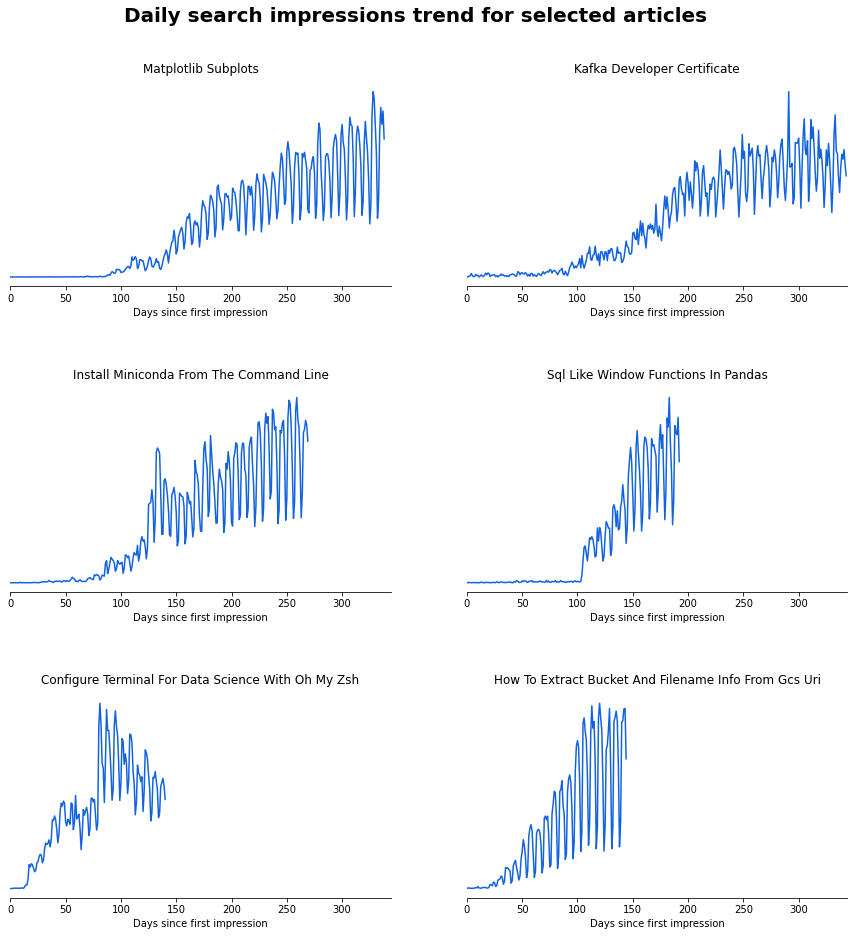

In [19]:
# set matplotlib formatting (optional)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.titlepad"] = 10


def reformat_title(title: str) -> str:
    split_title = " ".join(title.split("_"))
    split_title = " ".join(split_title.split("-"))
    return split_title.title()


# code snippet adapted from engineeringfordatascience.com/posts/matplotlib_subplots/
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)

ncols = 2
nrows = len(posts) // ncols + (len(posts) % ncols > 0)

max_days = len(ranking_pivot)

# loop through the length of tickers and keep track of index
for n, post in enumerate(posts):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)

    # filter df and plot ticker on the new subplot axis
    plotting_df = ranking_pivot[post]
    plotting_df.plot(ax=ax, color="#1363DF")

    # chart formatting
    ax.set_title(reformat_title(post))
    ax.set_xlabel("Days since first impression")
    ax.set_xlim(0, max_days)
    ax.set_yticks([])

plt.suptitle(
    "Daily search impressions trend for selected articles",
    y=0.95,
    fontsize=20,
    fontweight="bold",
)

plt.show()

The matplotlib and Kafka articles (top row) are two of my oldest on the website. It took around 100 days for them to start ranking on Google. Comparatively, the Oh My Zsh and GCS URI information articles (bottom row), that were published much more recently, only took 25-50 days to start seeing significant impressions on Google.

I have read that Google will rank articles on more mature websites more quickly, which seems to be the case here. 25 days still feels like a lifetime when publishing content online but at least things are improving.

My search traffic is very weekly seasonal, with many more searches during the week which then falls off at the weekend -- makes sense as most developers will be searching for answers to questions when they are working during the week. Interestingly, the Kafka and Oh My Zsh articles show less weekly seasonaility that the other articles. Maybe developers spend more time at the weekend on tasks less related to their work such as revising for exams or fiddling with their configurations.

## Conclusion

In this article we have demonstrated how to connect to your Google Search Console data and authenticate using service accounts and service account impersonation.

If you are familiar with the command line, you should consider using service account impersonation instead of downloading key files to authenticate your service account API calls. Service account impersonation removes the need for downloading and sharing key files which could be a security risk, particularly if you need to give other people access to your project.

The Search Console API provides very granular data across a multitude of dimensions ripe for analysis. With some basic Python skills you can answer many questions in an efficient and automated fashion, free from the limited Search Console user interface.

Happy coding!

### Resources

- [Impersonated credentials with Google Auth Python Library](https://google-auth.readthedocs.io/en/master/reference/google.auth.impersonated_credentials.html)
- [Article on service account impersonation](https://www.jhanley.com/google-cloud-improving-security-with-impersonation/)